## Preparing MetaData

Loading Json File into a DataFrame

In [2]:
import pandas as pd
import json

# Replace 'your_file.json' with the actual path to your JSON file
file_path = 'classification.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
    # Load JSON data from the file
    json_data_str = file.read()

# Parse JSON data from the string
json_data = json.loads(json_data_str)

# Create a list of dictionaries to pass to the DataFrame constructor
data_for_dataframe = []

for key, value in json_data.items():
    for img_name, class_name in value.items():
        data_for_dataframe.append({'key': key, 'image name': img_name, 'class name': class_name})

# Create a Pandas DataFrame
df = pd.DataFrame(data_for_dataframe)

# Display the DataFrame
df.head()


,key,image name,class name
0,1,060000.png,Blot/Gel
1,1,060001.png,Blot/Gel
2,1,060002.png,Blot/Gel
3,1,060003.png,Blot/Gel
4,1,060100.png,Blot/Gel


In [3]:
df['class name'].value_counts()

Blot/Gel      27440
Microscopy    18110
Macroscopy     1194
FACS           1061
Name: class name, dtype: int64

In [4]:
df['class name'].value_counts()

Blot/Gel      27440
Microscopy    18110
Macroscopy     1194
FACS           1061
Name: class name, dtype: int64

In [5]:
df.isnull().sum() #No Missing Values

key           0
image name    0
class name    0
dtype: int64

In [6]:
df.isnull().sum() #No Missing Values

key           0
image name    0
class name    0
dtype: int64

#### Naming each file a unique name 

In [7]:
# Generate new image names using a global counter
df['new image name'] = range(1, len(df) + 1)
df['new image name'] = df['new image name'].astype(str) + '.png'

# Display the updated DataFrame
df.head()

,key,image name,class name,new image name
0,1,060000.png,Blot/Gel,1.png
1,1,060001.png,Blot/Gel,2.png
2,1,060002.png,Blot/Gel,3.png
3,1,060003.png,Blot/Gel,4.png
4,1,060100.png,Blot/Gel,5.png


In [ ]:
#do not run this again as it will modify files in the system
import os

image_directory = "biofors_images"

# Rename the actual files on the filesystem
for index, row in df.iterrows():
    source_path = os.path.join(image_directory, str(row['key']), row['image name'])
    destination_path = os.path.join(image_directory, str(row['key']), row['new image name'])
    os.rename(source_path, destination_path)

df.head()

In [8]:
df = df.drop(['image name'], axis = 1)

In [9]:
df.head()

,key,class name,new image name
0,1,Blot/Gel,1.png
1,1,Blot/Gel,2.png
2,1,Blot/Gel,3.png
3,1,Blot/Gel,4.png
4,1,Blot/Gel,5.png


### Storing in class wise folders

In [ ]:
#Do not run this again as it will modify files in the dataset

import shutil
import os

# Define the base directory where subfolders will be created
base_directory = "biofors_images"

# Create subfolders for each unique class
unique_classes = df['class name'].unique()

for class_name in unique_classes:
    class_directory = os.path.join(base_directory, class_name)
    os.makedirs(class_directory, exist_ok=True)

# Move images to their respective class subfolders
for index, row in df.iterrows():
    source_path = os.path.join(base_directory, str(row['key']), row['image name'])
    destination_path = os.path.join(base_directory, row['class name'], row['image name'])
    
    # Move the image file
    shutil.move(source_path, destination_path)

# After moving, you can remove the original key-wise directories
for key in df['key'].unique():
    key_directory = os.path.join(base_directory, str(key))
    shutil.rmtree(key_directory, ignore_errors=True)

# Display the updated DataFrame
df


### Conclusion

Initially, we have a dataset of 47,805 images belonging to 4 classes. However, there is class imbalance present in our data which may affect the model. Macroscopy and FACS contain only 1k images.

#### How to solve class imbalance and introduce diversity in the dataset?
* Augment the data to produce more images
* Undersample the larger classes
* Introduce a negative class and other classes in the dataset for diversity

In [11]:
df['class name'].value_counts()

Blot/Gel      27440
Microscopy    18110
Macroscopy     1194
FACS           1061
Name: class name, dtype: int64

We can see that Macroscopy and FACS classes are very small compared to the other classes. So lets augment data from these classes.

### Augmenting using Keras on Blob/Gel and Macroscopy.

In [12]:
import Augmentor

def augment_data(input_folder, output_folder, num_augmented_samples):
    # Create an Augmentor pipeline for the input folder
    pipeline = Augmentor.Pipeline(input_folder, output_directory=output_folder)

    # Add desired augmentation operations
    pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    pipeline.flip_left_right(probability=0.5)
    pipeline.flip_top_bottom(probability=0.5)
    pipeline.zoom_random(probability=0.3, percentage_area=0.8)
    pipeline.shear(probability=0.3, max_shear_left=10, max_shear_right=10)
    pipeline.random_distortion(probability=0.2, grid_width=4, grid_height=4, magnitude=8)
    pipeline.histogram_equalisation(probability=0.2)

    # Number of augmented samples to generate
    pipeline.sample(num_augmented_samples)

In [ ]:
#do not run this code again 

# Path to your macroscopy images
macroscopy_input_folder = "class_wise images/Macroscopy"
macroscopy_output_folder = "Augmented Images/Macroscopy"

# Path to your FACS images
facs_input_folder = "class_wise images/FACS"
facs_output_folder = "Augmented Images/FACS"

# Number of augmented samples to generate for each dataset
num_augmented_samples = 2000

# Augment macroscopy images
augment_data(macroscopy_input_folder, macroscopy_output_folder, num_augmented_samples)

# Augment FACS images
augment_data(facs_input_folder, facs_output_folder, num_augmented_samples)

Now, that we have a moderately sized dataset, lets undersample the exceptionally larger classes. 

We can undersample randomly, but to extract only the best quality images, we ran this code to remove low quality images and only add the good quality images to our dataset.

### Remove Extra images from larger classes 

In [ ]:
#do not run this code again as it will modify files in the system.

import os
import cv2
import numpy as np

# Function to check if an image is black and white
def is_black_and_white(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Check if all pixel values are either close to 0 (black) or close to 255 (white)
    unique_colors = np.unique(gray)
    return len(unique_colors) <= 4

# Function to check image quality and size
def is_good_quality(image_path, min_size=100, min_variance=100):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        return False
    
    # Check if the image is black and white
    if is_black_and_white(image):
        return True
    
    # Calculate image size
    height, width, _ = image.shape
    min_dimension = min(height, width)
    
    # Check if image size is greater than minimum size
    if min_dimension < min_size:
        return False
    
    # Check image quality (you can replace this with your own image quality assessment method)
    # Here, we use the variance of the Laplacian method
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    if variance < min_variance:
        return False
    
    return True

# Define the base directory where images are located
base_directory = "the big classes"

# Define the output directory to save filtered images
output_directory = "filtered_images"

# Define the minimum size threshold for images
min_size_threshold = 100

# Define the minimum variance threshold for images
min_variance_threshold = 500

# Define the maximum number of images to save per class folder
max_images_per_class = 2500

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Initialize counters for the number of images processed and saved
num_images_processed = 0
num_images_saved = 0

# Iterate through each class folder
for class_name in os.listdir(base_directory):
    class_directory = os.path.join(base_directory, class_name)
    output_class_directory = os.path.join(output_directory, class_name)
    
    # Create the output class directory if it doesn't exist
    if not os.path.exists(output_class_directory):
        os.makedirs(output_class_directory)
    
    # Initialize counter for the number of images saved for the current class
    num_images_saved_for_class = 0
    
    # Iterate through each image in the class folder
    for image_name in os.listdir(class_directory):
        image_path = os.path.join(class_directory, image_name)
        
        # Check if the image is of good quality and size
        if is_good_quality(image_path, min_size=min_size_threshold, min_variance=min_variance_threshold):
            # Check if the maximum number of images per class has been reached
            if num_images_saved_for_class >= max_images_per_class:
                break
            
            # Copy the image to the output directory
            output_image_path = os.path.join(output_class_directory, image_name)
            cv2.imwrite(output_image_path, cv2.imread(image_path))
            num_images_saved += 1
            num_images_saved_for_class += 1
        
        num_images_processed += 1

print(f"Processed {num_images_processed} images.")
print(f"Saved {num_images_saved} images after filtering.")

After this, we have finally processed our dataset. 
Also, we have added 3 more classes namely 
* X-Rays
* CT Scans
* Negative data (graphs, charts, tables)

* https://www.kaggle.com/datasets/sunedition/graphs-dataset/data
* https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
* https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset?select=COVID



The final dataset has approximately 2.5k to 3k images of each class.
The classes are ['Microscopy', 'Macroscopy', 'FACS', 'Blob/gel', 'CT Scan', 'X-Rays', 'Negative data']

### Data Visualization

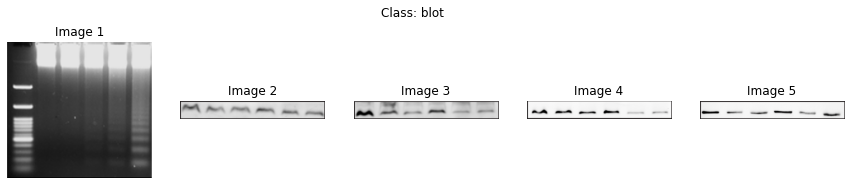

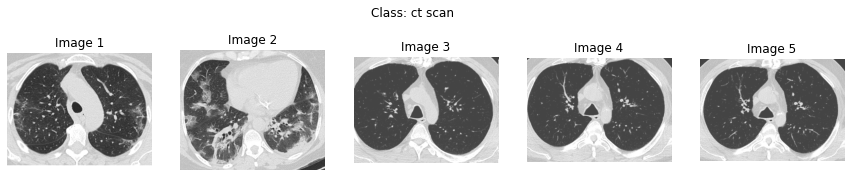

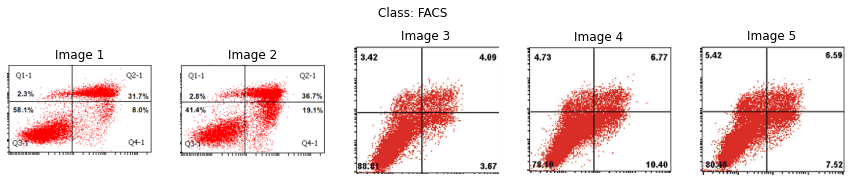

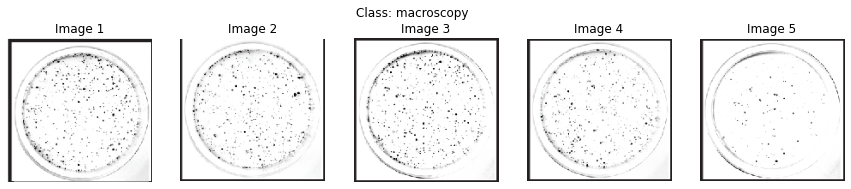

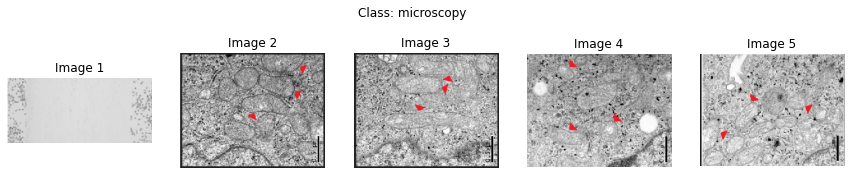

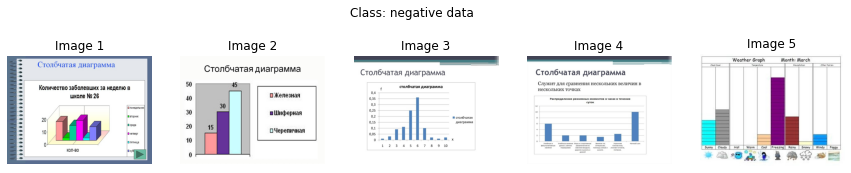

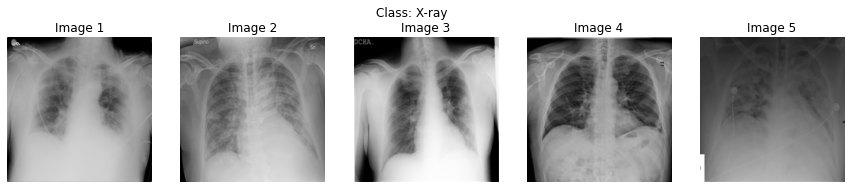

In [15]:
import os
import cv2
import matplotlib.pyplot as plt
# Path to the directory containing your image data
data_dir = "small data subset"

# List of classes (subdirectories) in your data directory
classes = os.listdir(data_dir)

# Set the number of images to display per class
num_images_per_class = 5

# Loop through each class and display some images
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)[:num_images_per_class]
    
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Class: {class_name}")
    
    for i, image_file in enumerate(image_files, 1):
        image_path = os.path.join(class_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (OpenCV loads images in BGR format)
        
        plt.subplot(1, num_images_per_class, i)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image {i}")
    
    plt.show()


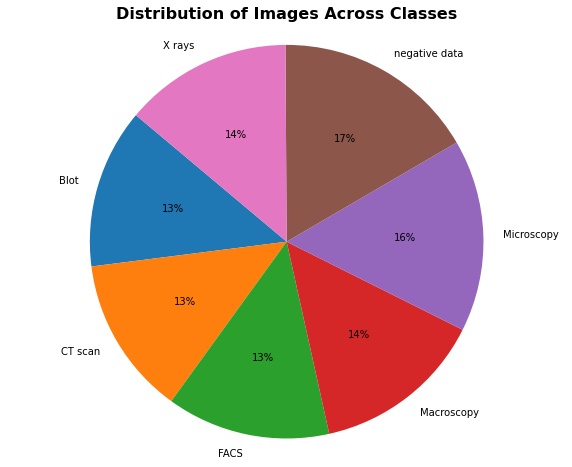

In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the directory containing your image data
data_dir = "class_wise images"

# List of classes (subdirectories) in your data directory
classes = os.listdir(data_dir)

# Count the number of images in each class
class_image_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in classes}

# Set Seaborn style

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(class_image_counts.values(), labels=class_image_counts.keys(), autopct='%.0f%%', startangle=140)
plt.title('Distribution of Images Across Classes', fontsize=16, fontweight='bold')
plt.axis('equal')  # Ensure the pie chart is circular
plt.show()
